# Optimizing Dry Bean Sorting into Classes using Classification with K-nearest neighbors

## Introduction:

Dry beans, scientifically known as Phaseolus vulgaris L., come in different varieties and are an important crop produced globally (Beebe et al., 2013). Cultivating mixed bean species rather than a single variety is common in Turkish agriculture, as well as in other Asian countries. This results in economic losses, as it is more difficult to process and sell mixed bean types. Turkey has several varieties of dry beans, including Barbunya, Battal, Bombay, Calı, Dermason, Horoz, Tombul, Selanik, and Seker. However, the market value of dry beans depends on the specific type of bean, and some beans are sold for higher prices than others.

The cultivation of the seven different beans together makes sorting them a crucial task (Koklu & Ozkan, 2020). Rather than selling them as a mixed batch, farmers can make more profit by sorting them by bean type. Manual classification of bean seeds can be error-prone and time-consuming, especially when dealing with high production volumes. Manual sorting is also expsensive and inconsistent concerning accuracy, which has led to growing interest in automatic sorting systems. Computer algorithms can analyze images of seeds and classify them based on features like size and shape, making sorting efficient and less labor-intensive than manual sorting.  A seed classification system would assist farmers in obtaining uniform seed varieties from crop production while reducing the time and error of manual sorting.

In this project, we are interested in seed classification within the context of our [dataset](https://archive.ics.uci.edu/ml/datasets/dry+bean+dataset), which identifies the seven different types of dry beans cultivated in Turkey based on the market situation and their physical features according to the Turkish Standards Institution. This research uses images of seven varieties of dry beans generated by a computer vision system, examining 16 features of the grains (Koklu & Ozkan, 2020). 

Our aim in this project is to create a k-NN classifier that can classify dry bean seeds uniformly and accurately, using the dataset from this study.

**Predictive question**: Can we accurately predict bean type (Seker, Barbunya, Bombay, Cali, Dermosan, Horoz, and Sira) using the physical features of the dry beans? 

Figure 1: Image of the Seven Types of Dry Beans

![](https://ars.els-cdn.com/content/image/1-s2.0-S0168169919311573-gr3.jpg)

source: https://www.sciencedirect.com/science/article/pii/S0168169919311573

### Variables of Interest:

| Variable Name  | Description                                 |
|--------|---------------------------------------------|
| Area (A)     | The area of a bean zone and the number of pixels within its boundaries.            |
|Perimeter (P)    | Bean circumference is defined as the length of its border.         |
| Major axis length (L)    | The distance between the ends of the longest line that can be drawn from a bean     |
|  Minor axis length (l)    | The longest line that can be drawn from the bean while standing perpendicular to the main axis |
| Aspect ratio (K)     | Defines the relationship between L and l           |
|Eccentricity (Ec)    | Eccentricity of the ellipse having the same moments as the region        |
| Convex area (C)    | Number of pixels in the smallest convex polygon that can contain the area of a bean seed      |
|  Equivalent diameter (Ed)   | The diameter of a circle having the same area as a bean seed area. |
| Extent (Ex)    |The ratio of the pixels in the bounding box to the bean area.            |
|Solidity (S)    | Also known as convexity. The ratio of the pixels in the convex shell to those found in beans          |
| Roundness (R)    |Calculated with the following formula: (4piA)/(P^2)   |
|  Compactness (CO)    |Measures the roundness of an object: Ed/L |
| ShapeFactor1 (SF1)    |Not specified in orginal dataset         |
|ShapeFactor2 (SF2)    |Not specified in orginal dataset         |
| ShapeFactor3 (SF3)   |Not specified in orginal dataset        |
|  ShapeFactor4 (SF4)   |Not specified in orginal dataset  |
| Class   | Bean type (Seker, Barbunya, Bombay, Cali, Dermosan, Horoz and Sira)|


Table 1: Variables of interest in the bean dataset

### Methods & Results:

In [9]:
# Download libraries

options(repr.matrix.max.rows = 6)
library(tidyverse)
library(tidymodels)
library(kknn)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks r

In [10]:
# Read dataset

url <- "https://github.com/NaziaNadir/dsci-100-2023-007-group-8/raw/main/Dry_Bean_Dataset.csv"
bean_data <- read_csv(url)|> mutate(Class = as_factor(Class))

# remove missing values if any
bean_data <- filter(bean_data, rowSums(is.na(bean_data)) != ncol(bean_data))

Rows: 13611 Columns: 17
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (1): Class
dbl (16): Area, Perimeter, MajorAxisLength, MinorAxisLength, AspectRation, E...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [11]:
#Wrangle/clean data 

clean_bean_data <- bean_data |>
mutate(Class= as_factor(Class))

clean_bean_data <- na.omit(clean_bean_data)

glimpse(clean_bean_data)

Rows: 13,611
Columns: 17
$ Area            <dbl> 28395, 28734, 29380, 30008, 30140, 30279, 30477, 30519…
$ Perimeter       <dbl> 610.291, 638.018, 624.110, 645.884, 620.134, 634.927, …
$ MajorAxisLength <dbl> 208.1781, 200.5248, 212.8261, 210.5580, 201.8479, 212.…
$ MinorAxisLength <dbl> 173.8887, 182.7344, 175.9311, 182.5165, 190.2793, 181.…
$ AspectRation    <dbl> 1.197191, 1.097356, 1.209713, 1.153638, 1.060798, 1.17…
$ Eccentricity    <dbl> 0.5498122, 0.4117853, 0.5627273, 0.4986160, 0.3336797,…
$ ConvexArea      <dbl> 28715, 29172, 29690, 30724, 30417, 30600, 30970, 30847…
$ EquivDiameter   <dbl> 190.1411, 191.2728, 193.4109, 195.4671, 195.8965, 196.…
$ Extent          <dbl> 0.7639225, 0.7839681, 0.7781132, 0.7826813, 0.7730980,…
$ Solidity        <dbl> 0.9888560, 0.9849856, 0.9895588, 0.9766957, 0.9908932,…
$ roundness       <dbl> 0.9580271, 0.8870336, 0.9478495, 0.9039364, 0.9848771,…
$ Compactness     <dbl> 0.9133578, 0.9538608, 0.9087742, 0.9283288, 0.9705155,…
$ ShapeFactor1 

Table 2: Wrangled dataset

#### Data set exploration summary


In [12]:
# Name of each category in Class column
clean_bean_data |>
  pull(Class) |>
  levels()

[1] "SEKER"    "BARBUNYA" "BOMBAY"   "CALI"     "HOROZ"    "SIRA"     "DERMASON"

In [13]:
# Number and percentage of each category.
 
num_obs <- nrow(clean_bean_data)

bean_number <- clean_bean_data |>
  group_by(Class) |>
  summarize(
    count = n(),
    percentage = n() / num_obs * 100) |>
    arrange(count)

print(bean_number)

# A tibble: 7 × 3
  Class    count percentage
  <fct>    <int>      <dbl>
1 BOMBAY     522       3.84
2 BARBUNYA  1322       9.71
3 CALI      1630      12.0 
4 HOROZ     1928      14.2 
5 SEKER     2027      14.9 
6 SIRA      2636      19.4 
7 DERMASON  3546      26.1 


Table 3: Number and percentage of each type of bean in the dataset

The above count table shows that the class DERMASON has the highest number of observations. It occupies about 26.1 % of the total observations in the dataset while seed BOMBAY has the lowest number of observations with about 3.84% of the total observations. The different ratios of observations of each class might affect the classification model. However, the number of observations in each class is not very far off therefore resampling of data is essentially not required. 

In [14]:
set.seed(25)
#Create the train/ test split
bean_split <- initial_split(clean_bean_data, prop = 0.50, strata = Class)
bean_train <- training(bean_split)
bean_test <- testing(bean_split)

In [15]:
glimpse(bean_train)

Rows: 6,804
Columns: 17
$ Area            <dbl> 43145, 47149, 49755, 50167, 50575, 51015, 52839, 53525…
$ Perimeter       <dbl> 799.426, 857.690, 868.813, 873.825, 858.520, 859.253, …
$ MajorAxisLength <dbl> 273.4029, 300.2879, 332.0911, 309.8928, 314.3268, 327.…
$ MinorAxisLength <dbl> 201.2669, 200.3199, 191.9921, 206.7724, 205.4663, 198.…
$ AspectRation    <dbl> 1.358410, 1.499042, 1.729713, 1.498715, 1.529822, 1.65…
$ Eccentricity    <dbl> 0.6768132, 0.7449746, 0.8159441, 0.7448443, 0.7567789,…
$ ConvexArea      <dbl> 43812, 48091, 50783, 50937, 51389, 51718, 53489, 54660…
$ EquivDiameter   <dbl> 234.3799, 245.0142, 251.6943, 252.7343, 253.7599, 254.…
$ Extent          <dbl> 0.7661233, 0.7207674, 0.7342828, 0.7945989, 0.7121233,…
$ Solidity        <dbl> 0.9847759, 0.9804121, 0.9797570, 0.9848833, 0.9841600,…
$ roundness       <dbl> 0.8483671, 0.8054186, 0.8283120, 0.8256178, 0.8622733,…
$ Compactness     <dbl> 0.8572690, 0.8159311, 0.7579074, 0.8155538, 0.8073124,…
$ ShapeFactor1  

Table 4: Training data 

In [16]:
glimpse(bean_test)

Rows: 6,807
Columns: 17
$ Area            <dbl> 28395, 30008, 30279, 30519, 30685, 30917, 31091, 31107…
$ Perimeter       <dbl> 610.291, 645.884, 634.927, 629.727, 635.681, 640.765, …
$ MajorAxisLength <dbl> 208.1781, 210.5580, 212.5606, 212.9968, 213.5341, 213.…
$ MinorAxisLength <dbl> 173.8887, 182.5165, 181.5102, 182.7372, 183.1571, 184.…
$ AspectRation    <dbl> 1.197191, 1.153638, 1.171067, 1.165591, 1.165852, 1.15…
$ Eccentricity    <dbl> 0.5498122, 0.4986160, 0.5204007, 0.5137596, 0.5140809,…
$ ConvexArea      <dbl> 28715, 30724, 30600, 30847, 31044, 31280, 31458, 31423…
$ EquivDiameter   <dbl> 190.1411, 195.4671, 196.3477, 197.1243, 197.6597, 198.…
$ Extent          <dbl> 0.7639225, 0.7826813, 0.7756885, 0.7706818, 0.7715615,…
$ Solidity        <dbl> 0.9888560, 0.9766957, 0.9895098, 0.9893669, 0.9884358,…
$ roundness       <dbl> 0.9580271, 0.9039364, 0.9438518, 0.9671092, 0.9542398,…
$ Compactness     <dbl> 0.9133578, 0.9283288, 0.9237260, 0.9254804, 0.9256585,…
$ ShapeFactor1  

Table 5: Testing data


We can observe from glimpse in the code above that the training set contains 6804 observations, while the test set contains 6807 observations. This corresponds to a train / test split of 50% / 50%, as desired.

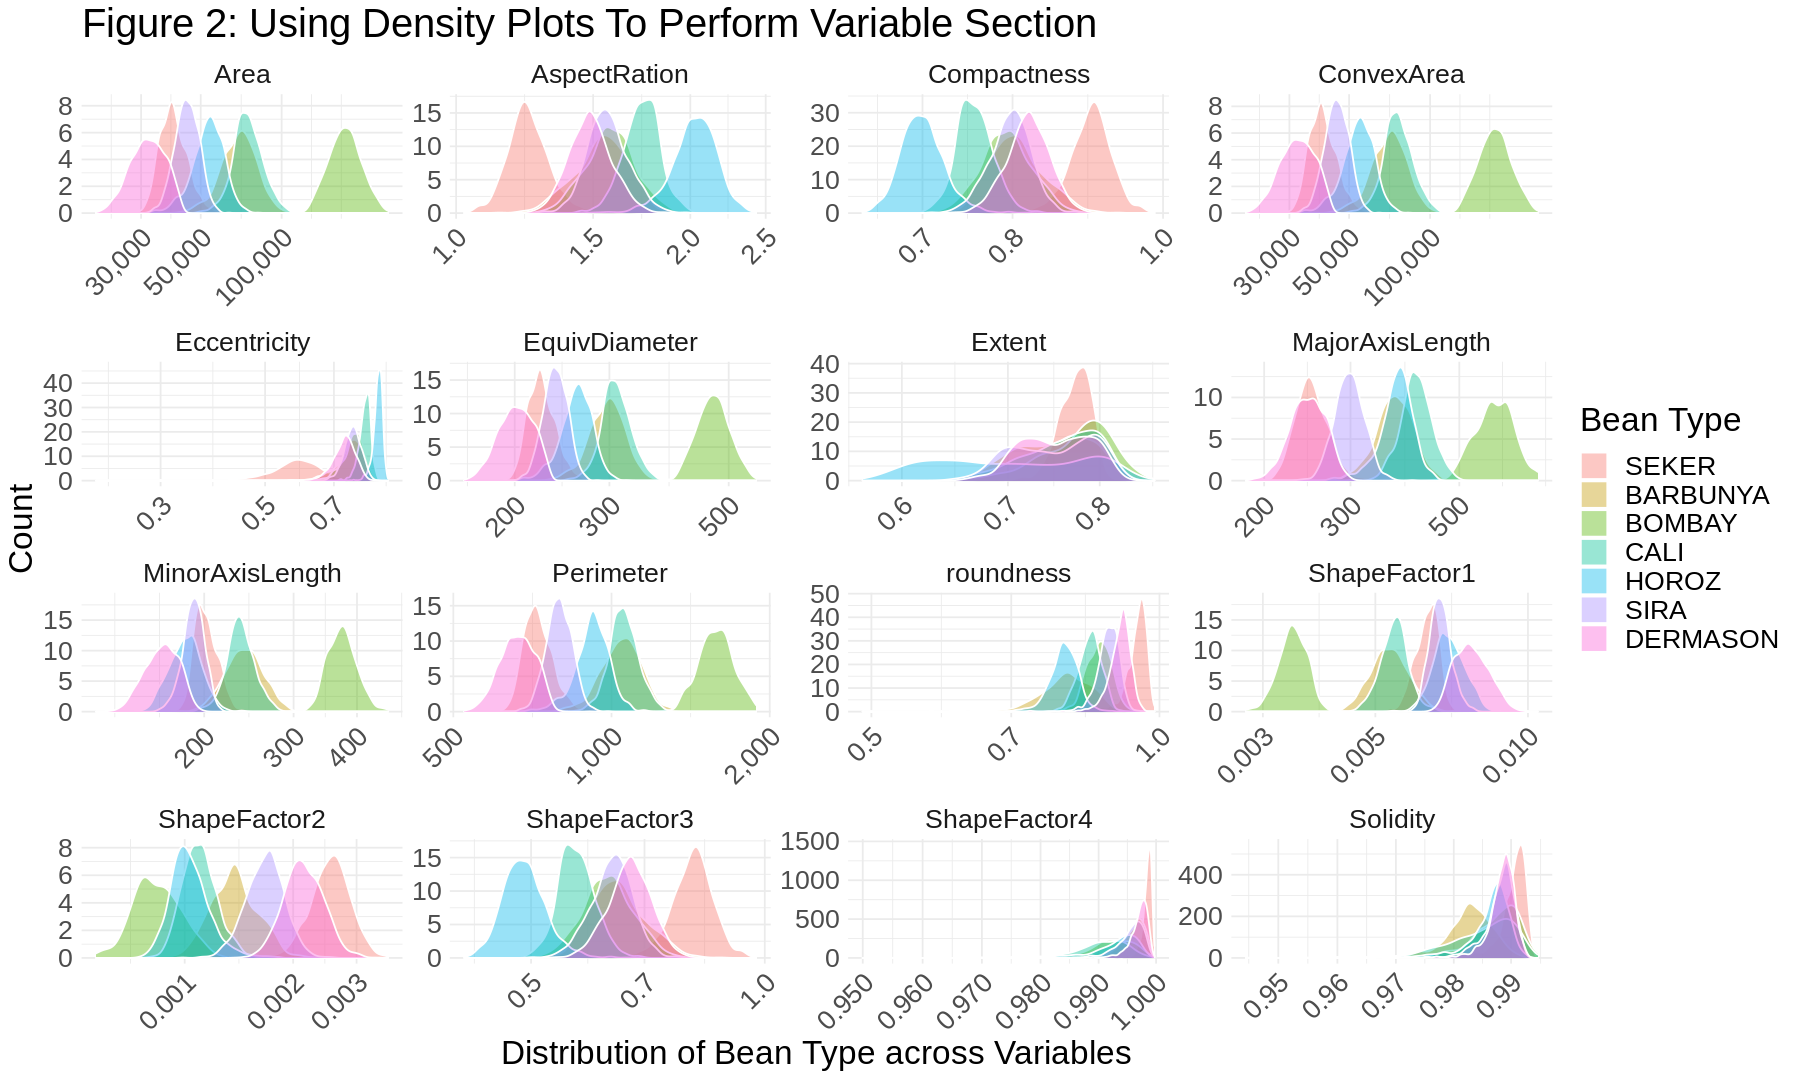

In [17]:
# Predictor selection
options(repr.plot.height = 9, repr.plot.width = 15)
density_plot <- bean_train |>
    pivot_longer(cols = -Class, names_to = 'category', values_to = 'value')  |> 
    ggplot(aes(value, fill = Class)) +
        geom_density(alpha = 0.4, colour = 'white') +
        facet_wrap(facets = vars(category), scales = 'free') +
        theme_minimal() +
        labs(x="Distribution of Bean Type across Variables", y="Count", fill="Bean Type")+
        ggtitle("Figure 2: Using Density Plots To Perform Variable Section")+
        theme(text = element_text(size = 20)) +
 theme(axis.text.x = element_text(angle = 45, hjust =1)) +
  scale_x_log10(labels = label_comma())
density_plot

To choose our predictors:

First, we removed variables we don't understand because the original dataset did not explain them. These include shape factors 1, 2, 3, and 4.

Next, we removed variables that convey similar things making them redundant. When it comes to using them as predictors, this will cause our model to place a greater emphasis on those predictors since they are accounted for twice. 
The aspect ratio is the relationship between the major and minor axis of an object. So, we removed the major axis and minor axis. The Area is similar to the Perimeter. So, we removed the area.

Lastly, we utilized histograms to visualize the distribution overlap of different variables. If the distributions between the graphs greatly overlap then it might not be a good predictor because if an unknown observation was used, it'd be within a cluster of many different bean types. If one distribution was skewed to the right and one distribution was skewed to the left (i.e. very little overlap), that could be an indication of a good predictor. Referring to figure 2, distribution of the solidity graph shows notable overlap between every class of bean; thus, this variable was removed.

Therefore, we are left with the following variables to be used in our classifier: **AspectRation, Compactness, ConvexArea, Eccentricity, EquivDiameter, Extent, Perimeter, and Roundness.**

In [18]:
#Update data set using only the chosen predictors
bean_train <- bean_train |>
select("AspectRation", "Compactness", "ConvexArea", "Eccentricity",
       "EquivDiameter", "Extent", "Perimeter", "roundness", "Class")

bean_test <- bean_test |>
select("AspectRation", "Compactness", "ConvexArea", "Eccentricity",
       "EquivDiameter", "Extent", "Perimeter", "roundness", "Class")

# Number each category in the test data for accuracy evaluation.

test_bean_number <- bean_test |>
  group_by(Class) |>
  summarize(
    count = n()) |>
    arrange(count)

print(test_bean_number)

# A tibble: 7 × 2
  Class    count
  <fct>    <int>
1 BOMBAY     256
2 BARBUNYA   647
3 CALI       822
4 HOROZ      964
5 SEKER     1010
6 SIRA      1332
7 DERMASON  1776


Table 6: Number of each type of bean in the test data

## **Variable means and standard deviations**

In [19]:
bean_mean <- bean_train|>
group_by(Class)|> 
summarise(mean_Perimeter = mean(Perimeter), 
                  mean_AspectRation = mean(AspectRation),
                  mean_Eccentricity = mean(Eccentricity),
                  mean_EquivDiameter = mean(EquivDiameter),
                  mean_roundness = mean(roundness),
                  mean_Compactness = mean(Compactness),
                  mean_Extent = mean(Extent), 
                  mean_ConvexArea = mean(ConvexArea))
print(bean_mean)

# A tibble: 7 × 9
  Class    mean_Perimeter mean_AspectRation mean_Eccentricity mean_EquivDiameter
  <fct>             <dbl>             <dbl>             <dbl>              <dbl>
1 SEKER              728.              1.24             0.582               225.
2 BARBUNYA          1048.              1.55             0.755               298.
3 BOMBAY            1584.              1.58             0.770               469.
4 CALI              1057.              1.73             0.815               309.
5 HOROZ              921.              2.03             0.868               261.
6 SIRA               796.              1.57             0.767               238.
7 DERMASON           665.              1.49             0.737               202.
# … with 4 more variables: mean_roundness <dbl>, mean_Compactness <dbl>,
#   mean_Extent <dbl>, mean_ConvexArea <dbl>


Table 7: Mean values of each predictor for each bean type




​​The table above shows the average of each variable by class. For Perimeter and EquivDiameter, SEKER and SIRA have similar means while BOMBAY has the highest mean. For roundness, and compactness, HOROZ, CALI, and BOMBAY have similar means while SEKER has the highest mean. For AspectRatio and Eccentricity, SEKER, DERMASON, and BARBUNYA have similar means while HOROZ has the highest mean.The above table summarizes the mean of each predictor variable grouped by its Class.
The varibales perimeter and ConvexArea have  highest mean value for BOMBAY and lowest for DERMASON. 
The mean of AspectRation and Eccentricity is highest for HOROZ while it is lowest for SEKER. 
The mean EquivDiameter is highest for BOMBAY  and it is lowest for  DERMASON .
The variables roundness, compactness and extent have highest mean values for seed SEKER and and lowest for HOROZ . 





In [20]:
# Table of standard deviation for each predictor by Class
bean_sd <- bean_train|>
group_by(Class)|>
summarise(sd_Perimeter = sd(Perimeter), 
          sd_AspectRation = sd(AspectRation),
          sd_Eccentricity = sd(Eccentricity),
          sd_EquivDiameter = sd(EquivDiameter),
          sd_roundness = sd(roundness),
          sd_Compactness = sd(Compactness),
          sd_Extent = sd(Extent),
          sd_ConvexArea = sd(ConvexArea))
          
print(bean_sd) 

# A tibble: 7 × 9
  Class    sd_Perimeter sd_AspectRation sd_Eccentricity sd_EquivDiameter
  <fct>           <dbl>           <dbl>           <dbl>            <dbl>
1 SEKER            48.4          0.0817          0.0722             13.3
2 BARBUNYA         90.7          0.125           0.0492             22.4
3 BOMBAY          116.           0.113           0.0387             31.8
4 CALI             68.4          0.0914          0.0224             19.6
5 HOROZ            68.5          0.132           0.0201             17.6
6 SIRA             44.8          0.0979          0.0330             12.3
7 DERMASON         50.3          0.0969          0.0399             14.7
# … with 4 more variables: sd_roundness <dbl>, sd_Compactness <dbl>,
#   sd_Extent <dbl>, sd_ConvexArea <dbl>


Table 8: Standard deviation values of each predictor for each bean type

The above table shows the spread of values for each predictor variable grouped by its Class. The standard deviation shows the spread of variables in a Class. 
The standard deviation for perimeter and ConvexArea is highest for BOMBAY and lowest for SIRA.
The varibales perimeter and ConvexArea have  highest standard deviation value for BOMBAY and lowest for DERMASON. 
The standard deviation of AspectRation and Eccentricity is highest for HOROZ while it is lowest for SEKER. 
The standard deviation EquivDiameter is highest for BOMBAY  and it is lowest for  DERMASON .
The variables roundness, compactness and extent have highest standard deviation values for seed SEKER and and lowest for HOROZ . 


### K Value Selection

In [21]:
# Five fold Cross validation
bean_vfold <- vfold_cv(bean_train, v = 5, strata = Class)

In [22]:
# Model specification
knn_spec <- nearest_neighbor(weight_func = "rectangular", 
                             neighbors = tune()) |>
                             set_engine("kknn") |>
                             set_mode("classification")
knn_spec

K-Nearest Neighbor Model Specification (classification)

Main Arguments:
  neighbors = tune()
  weight_func = rectangular

Computational engine: kknn 


In [23]:
# Generate the recipe and standarize the variables
bean_recipe <- recipe(Class ~ ., data = bean_train) |>
  step_scale(all_predictors()) |>
  step_center(all_predictors())
bean_recipe

Recipe

Inputs:

      role #variables
   outcome          1
 predictor          8

Operations:

Scaling for all_predictors()
Centering for all_predictors()

In [ ]:
# Generate a tibble to test different K values
k_vals <- tibble(neighbors = seq(from = 1, to = 15, by = 1))

In [25]:
# Feed the recipe and model specification into a workflow
knn_results <- workflow() |>
  add_recipe(bean_recipe) |>
  add_model(knn_spec) |>
  tune_grid(resamples = bean_vfold, grid = k_vals) |>
  collect_metrics() 
# Output the accuracy values
accuracies <- knn_results |>
  filter(.metric == "accuracy")

In [26]:
# Find the maximum accuracy
accuracies_max <- accuracies |>
arrange(mean)|>
tail(1)
accuracies_max

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
13,accuracy,multiclass,0.9131465,5,0.004402226,Preprocessor1_Model13


Table 9: Best k value to use in classifier

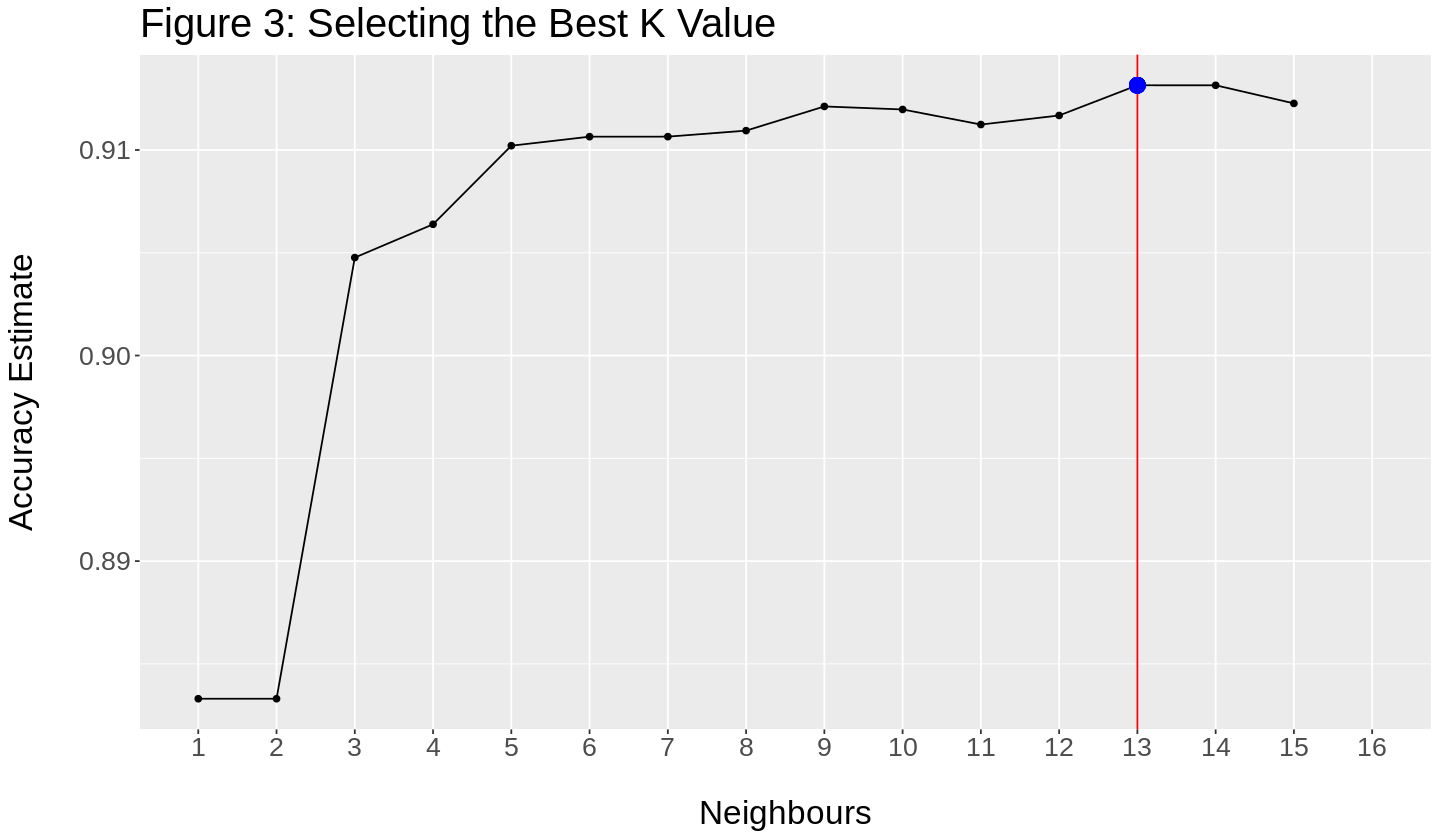

In [27]:
# Generate the graph to choose optimal K value
options(repr.plot.width = 12, repr.plot.height = 7)

ky <- accuracies |>
    filter(neighbors == 13) |>
    select(mean) |>
    pull()

cross_val_plot <- accuracies |> 
    ggplot(aes(x = neighbors, y = mean)) +
    geom_point() +
    geom_line() +
    geom_vline(xintercept = 13, colour = "red") +
    geom_point(aes(x = 13, y = ky), size = 4, colour = "blue") +
    labs(x = "\nNeighbours",
         y = "Accuracy Estimate\n",
         title = "Estimated Accuracies of k Neighbours") +
    scale_x_continuous(limits = c(1, 16),
                       breaks = seq(1, 16),
                       minor_breaks = seq(1, 16, 1)) +
    theme(text = element_text(size = 20),
          plot.caption = element_text(size = 20, hjust = 0))+
ggtitle("Figure 3: Selecting the Best K Value")

cross_val_plot

Based on the findings presented in Figure 3, it can be concluded that a value of k=13 provides the highest estimated accuracy. Moreover, the graph indicates that the estimated accuracy remains relatively stable even if we slightly increase or decrease k around the value of 13. Furthermore, selecting k=13 does not result in a computationally expensive training process. Therefore, considering all these factors, we would choose k=13 as the optimal value for the classifier.

In [28]:
# Make a new model specification for the best parameter value 

In [29]:
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 13) |>
  set_engine("kknn") |>
  set_mode("classification")

knn_fit <- workflow() |>
  add_recipe(bean_recipe) |>
  add_model(knn_spec) |>
  fit(data = bean_train)
knn_fit

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

• step_scale()
• step_center()

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = min_rows(13,     data, 5), kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.08656673
Best kernel: rectangular
Best k: 13

In [30]:
# Evaluate the estimated accuracy of the classifier 

In [39]:
bean_predictions <- predict(knn_fit, bean_test) |>
                    bind_cols(bean_test)

In [32]:
levels(bean_predictions$.pred_class) <- levels(bean_predictions$Class)
bean_predictions |>
metrics(truth = Class, estimate =.pred_class)|>
filter(.metric == "accuracy")

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,multiclass,0.9127369


Table 10: Accuracy of the classifier 

# Summary Table

In [33]:
# Generate confusion matrix
confusion <- bean_predictions |>
             conf_mat(truth = Class, estimate = .pred_class)
confusion

          Truth
Prediction SEKER BARBUNYA BOMBAY CALI HOROZ SIRA DERMASON
  SEKER      948        7      0    2     0   19       44
  BARBUNYA     4      550      0   21     3    5        1
  BOMBAY       0        0    256    0     0    0        0
  CALI         0       74      0  782    20    3        0
  HOROZ        0        3      0    8   902   10        2
  SIRA        42       13      0    9    33 1175      129
  DERMASON    16        0      0    0     6  120     1600

Table 11: Confusion matrix for the classifier

In [34]:
# Number of beans in each category in the test data.
test_bean_number <- bean_test |>
  group_by(Class) |>
  summarize(
    count = n()) |>
    arrange(count)

print(test_bean_number)

# A tibble: 7 × 2
  Class    count
  <fct>    <int>
1 BOMBAY     256
2 BARBUNYA   647
3 CALI       822
4 HOROZ      964
5 SEKER     1010
6 SIRA      1332
7 DERMASON  1776


Table 11: Number of beans in each category in the test data                                                                                                                                                                                       

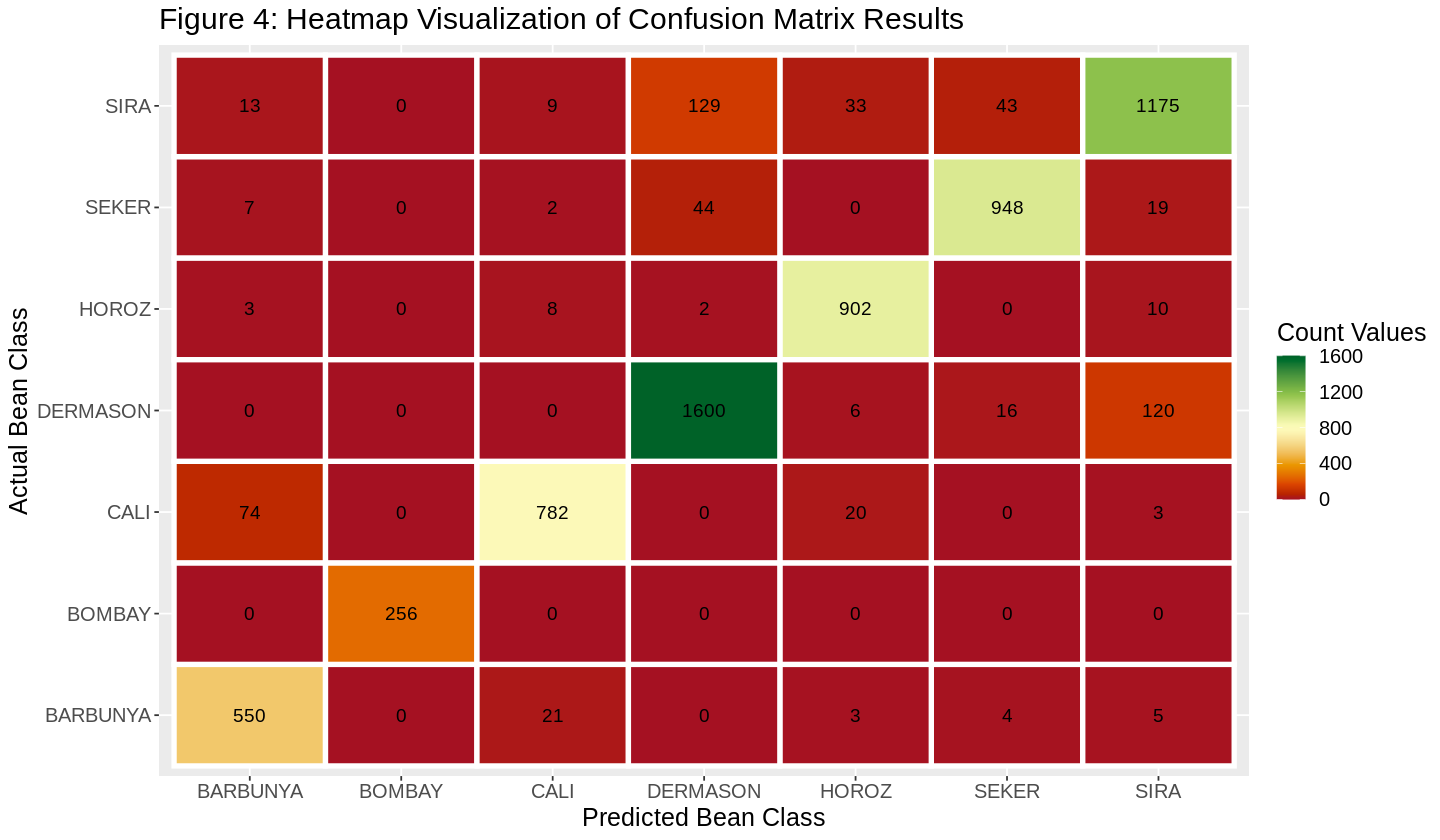

In [35]:
# Heat map based on the confusion matrix
value =c(948,  7,  0,    2,     0,   19 ,      44,
      4,   550,      0,   21,     3,    5,  0,
      0,    0,    256,    0,     0,    0,    0,
      0,    74,      0,  782,    20,    3,    0,
      0,     3,      0,    8,   902,   10,    2,
      43,    13,      0,    9,    33, 1175,   129,
      16,     0,      0,   0,     6,  120,    1600)
predicted <- c(rep(c("SEKER", "BARBUNYA", "BOMBAY", "CALI", "HOROZ", "SIRA", "DERMASON"), 7))
actual <- c(rep("SEKER",7), rep("BARBUNYA",7), rep("BOMBAY",7),rep("CALI",7),rep("HOROZ",7),rep("SIRA",7),rep( "DERMASON",7))

conf_matriz <- tibble(actual, predicted, value)


# Heatmap for correlation of variables
heat_map <- ggplot(conf_matriz, aes(x = predicted, y= actual , fill = value)) +
  geom_tile(color = "white",
            lwd = 1.5,
            linetype = 1)+
    xlab("Predicted Bean Class")+
    ylab("Actual Bean Class")+
  geom_text(aes(label = value), color = "black", size = 4)+
  scale_fill_gradientn(colors = hcl.colors(30, "RdYlGn")) +
 guides(fill = guide_colourbar(title = "Count Values"))+
  ggtitle("Figure 4: Heatmap Visualization of Confusion Matrix Results")+
    theme(text=element_text(size=15))
heat_map 


Figure 4 represents the confusion matrix outcomes. The colour gradient ranges from green to red with green for higher number of observations and red for small number of observations. 

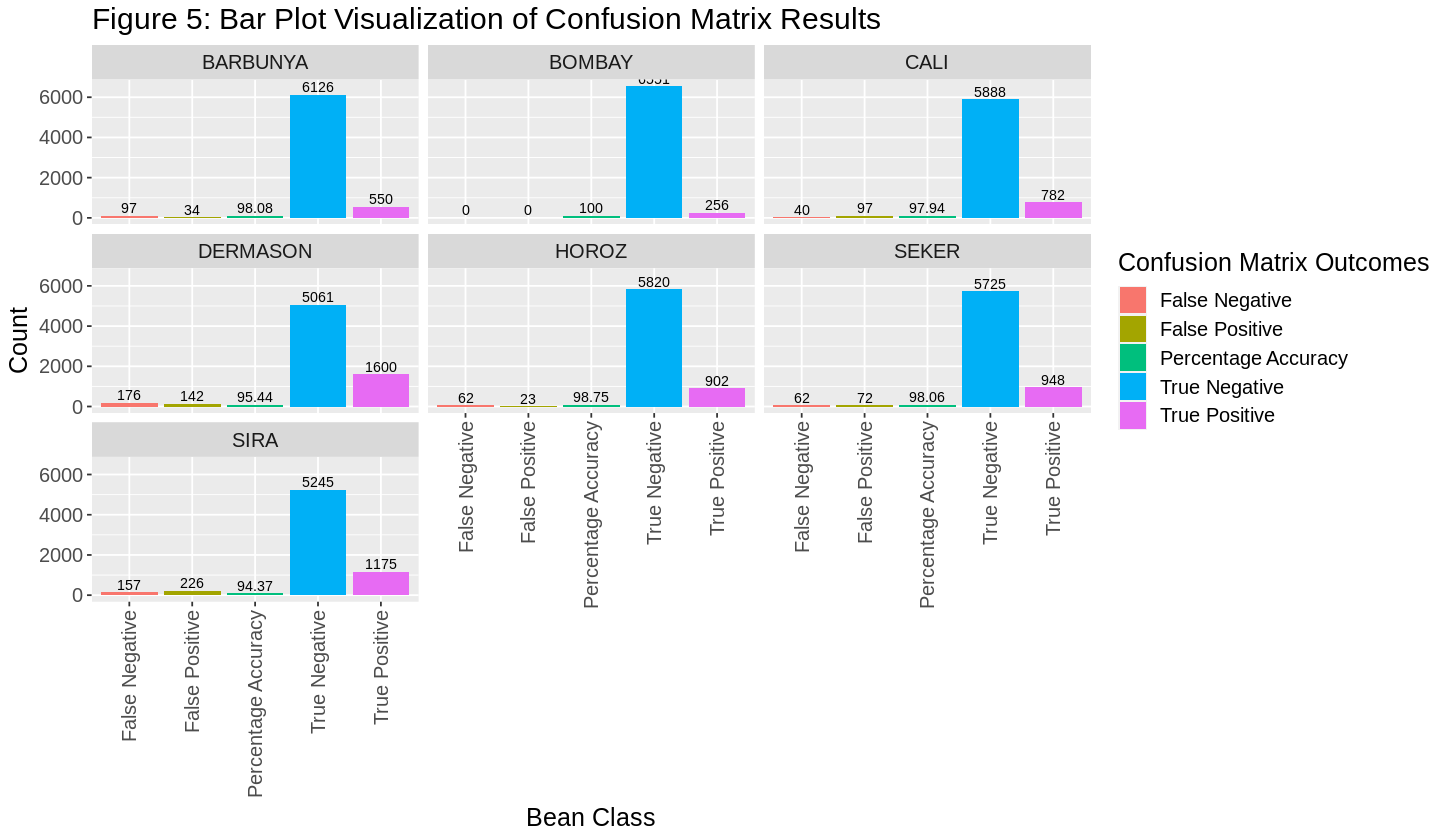

In [42]:
# Bar graph showing true positive, true negative, false positive, false negative and accuracies for each
# class based on the confusion matrix
confusion_values = c(948,5725,72,62,round((((948+5725)/(946+5725+72+62))*100),2),
                     550, 6126,34,97,  round((((550+6126)/(550+6126+34+97))*100),2), 
                     256, 6551,0,0, round((((256+6551)/(256+6551+0+0))*100), 2),
                     782, 5888, 97,40,round((((782+5888)/(785+5888+97+40))*100),2), 
                     902,5820, 23, 62,  round((((902+5820)/(902+5820+23+62))*100),2),
                     1175, 5245, 226,157,  round((((1175+5245)/(1175+5245+226+157))*100),2),
                     1600, 5061,142, 176, round((((1600+5061)/(1600+5061+142+176))*100),2))
    
class_name <- c(rep("SEKER",5), rep("BARBUNYA",5), rep("BOMBAY",5),rep("CALI",5),rep("HOROZ",5),rep("SIRA",5),rep( "DERMASON",5))
conf_outcomes <- c(rep(c("True Positive", "True Negative", "False Positive", "False Negative", "Percentage Accuracy"), 7))

conf_tibble <- tibble(class_name, conf_outcomes, confusion_values)   

bean_bar <- ggplot(conf_tibble, aes(x = conf_outcomes, y = confusion_values, fill= conf_outcomes)) +
  geom_bar(stat = "identity", positio = position_dodge()) +
  labs(x="Bean Class", y = "Count", fill = "Confusion Matrix Outcomes") +
  ggtitle("Figure 5: Bar Plot Visualization of Confusion Matrix Results") +
  facet_wrap(~class_name)+
  geom_text(aes(label = confusion_values), position = position_dodge(width = 0.2), vjust = -0.25, size=3)+
  theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))+
  theme(text = element_text(size=15))
  

bean_bar 

From Figure 5, it is clear that the classifier accurately predicted all the beans for the class BOMBAY, leading to a 100% accuracy for this class. It classified 550 BARBUNYA correctly out of 647, with an accuracy of 98.08%. Moreover, 782 CALI beans were correctly classified out of 822, leading to an accuracy of 97.94% for this class. Similarly, 902 HOROZ beans out of 964 were correctly classified with an accuracy of 98.75%. Additionally, 948 SEKER beans out of 1010 were correctly classified with an accuracy of 98.06%. Therefore, the classifier is performing well for these classes, especially because CALI, BOMBAY, SEKER, and BARBUNYA are some of the highest-priced bean varieties, with SEKER costing $10/kg (Marché Istanbul, n.d.), BARBUNYA costing $25.73/kg (Grand Turkish Bazaar, n.d.), BOMBAY costing 10.81$/kg (Grand Turkish Bazaar, n.d.) and CALI costing $10.79/kg (O.M. Foods, n.d.).
The high accuracy for HOROZ (i.e., 98.75%) is also useful since it is one of the cheaper varieties, costing around $6/kg (Turkish Grocery, n.d.). Accurately predicting this class will avoid mixing these cheaper beans with high-value beans. Overall, the classifier accurately classified the five classes of beans, with an accuracy of around 98% for each class, which is good.


Out of 1332 SIRA beans, 1175 were correctly classified, resulting in an accuracy of 94.37%. Similarly, 1600 DERMASON beans out of 1776 were correctly classified with an accuracy of 95.44%. However, for DERMASON and SIRA, false positive and false negative rates are relatively higher, which has led to lower prediction accuracies for these classes. The low accuracy for DERMASON is especially concerning since it is among the highly valued and high-priced bean varieties, costing $10.30/kg (Grand Turkish Bazaar, n.d.). On the other hand, SIRA costs $6.50/kg (Marketim, n.d.), and higher accuracy would have been better to avoid mixing these cheaper beans with the more expensive beans. 
           

### Discussion:

##### What did we find?


As seen in the above data analysis, the KNN classifier has an accuracy of about 91% in classifying seven different classes of seed which are 'SEKER', 'BARBUNYA', 'BOMBAY', 'CALI', 'HOROZ', 'SIRA', and 'DERMASON'. The confusion matrix and heatmap represent the summarisation of the predicted results (Figure 4 and 5), which is a significant tool for evaluating the accuracy of our classifier model.

The above heatmap, Figure 5, gives a visual representation of the data analysis and accuracy of the model. The overall accuarcy of the model is sufficicent for our purposes as it predicts about 91% correct observations. Notably, there were some seed types that were misclassified. The diagonal of the heatmap depicts the correct predictions made by the model. We can draw a few conclusions from the heatmap, which represents misclassified seeds (lower counts) with red colour, while it depicts high misclassfication with orange. By observing the heatmap we find that about 120 DERMASON seeds were identified SIRA (as it has an orange colour) and about 45 DERMASON seeds were identified SEKER (light orange). Also, about 122 SIRA seeds were identified DERMASON and therefore, having orange colour for depiction.This suggests that there might some physical similarities between DERMASON and SIRA seeds. In addition to this about 21 CALI seeds were misclassified as BARBUNYA and about 74 BARBUNYA seeds were misclassified as CALI. This suggests that there may be some overlap in the features of these two types of seeds, making it challenging for the classifier to differentiate between them accurately.



##### Did we expect these findings?


Based on the dataset, we did not expect the classification model to achieve a 91% accuracy. The dataset contained 16 different variables, which could be used as predictors in the classification model. The higher number of predictors in a model often corresponds to less accuracy. Other than this the target variable of the dataset which is the CLASS has seven different types of seed. We saw this as a potential reason to decrease the accuracy of the model as the class 'BOMBAY' had about 3.84% observations in the dataset while the class 'DERMASOn' had about 26.1% observations in the dataset. This makes the data close to an imbalanced dataset and might make the model biassed towards one type.Other than this the seven different types of seed types increases the complexity and makes it challenging for the model to predict accurate seed type.

A 91% accuracy classifier can be considered good in some contexts, but it may not be sufficient in others. It ultimately depends on the user's needs and expectations. For our specific classifer, it had difficulty distinguishing between Dermason and Sira beans, which have different market values. Dermason beans are currently around 10 dollars per kg (Grand Turkish Bazaar, (n.d.)), while Sira beans 6 dollars per kg (Marketim,(n.d.)). This means that misclassifying a significant amount of beans can result in a big difference in profit for farmers. For example, misclassifying 1000 kg of Dermason beans as Sira beans would result in a loss of 4000 dollars. Similarly, misclassifying Barbunya beans as Cali beans could also result in substantial losses for farmers, given the large price difference between them. Barbunya beans are around 26 dollars per kg (Grand Turkish Bazaar, (n.d.)), while Cali beans are around 11 dollars per kg (O.M. Foods, (n.d.)). Misclassifying 1000 kg of Barbunya beans as Cali beans would result in a loss of 15,000 dollars. As such, farmers may have different expectations for their classifier's accuracy. Some may think a 91% accuracy is acceptable, while others may not. If a farmer believes that a 9% error rate is too high and will result in significant losses, they may consider the classifier insufficient. However, if a farmer believes that 91% accuracy is acceptable, they may use the classifier. Therefore, the effectiveness of a classifier is subjective to the user and their need for profit. A 91% accuracy rate may be good enough for some, but not for others.



##### What impact could such findings have?
The selection of the optimal seed species is a crucial issue for bean farmers and the market alike. With a wide range of genotypes cultivated across the globe, it is imperative to differentiate the finest seed variety from the mixed dry bean population. If this is not done, the market value of these heterogeneous bean species may witness a significant decline, as pointed out by Varankaya and Ceyhan (2012). Findings from this study have significant implications for the agricultural industry, as development of automated image classification technology can improve efficiency and accuracy of dry bean sorting, reducing labor costs. Success could lead to research on applications of image classification models to other agricultural products (e.g., crops and fruits), or examining socio-economic impacts of this technology via agriculture, specifically potential for job displacement.

##### What future questions could this lead to?  
It may be worth finding a method to prevent misclassification of Dermason seeds as Sira. One question that arises is if there are other features of these beans that could be added to the dataset to improve the accuracy of the model. We could also examine the extent to which this specific misclassification affects the quality and economic value of the final product. Taking these factors into consideration will help us answer the question of whether our classifier's accuracy is truly useful for the purpose of farming uniform seeds, or if it must be improved to make even more accurate predictions.

### References

 Beebe, S. E., Rao, I. M., Blair, M. W., & Acosta-Gallegos, J. A. (2013). Phenotyping common beans for adaptation to drought. Frontiers in Physiology, 4, 35-35. 
https://doi.org/10.3389/fphys.2013.00035

 KOKLU , M., &amp; OZKAN , I. A. (2020). Dry Bean Dataset. UCI Machine Learning Repository: Dry Bean Dataset Data set. Retrieved April 13, 2023, from https://archive.ics.uci.edu/ml/datasets/Dry+Bean+Dataset 


 Koklu, M., & Ozkan, I. A. (2020). Multiclass classification of dry beans using computer vision and machine learning techniques. Computers and Electronics in Agriculture, 174, 105507. https://doi.org/10.1016/j.compag.2020.105507
 

 Varankaya, S., & Ceyhan, E. (2012). Problems Encountered in Bean Farming in the Central Anatolia Region and Solution Suggestions. Selçuk Tarım Bilim. Journal. 26, 15–26.

 Image source: https://www.sciencedirect.com/science/article/pii/S0168169919311573

 O.M. Foods. (n.d.). Organic Cannellini Beans. O.M. Foods. Retrieved April 15, 2023, from https://www.omfoods.com/products/legumes-organic-cannelini-beans?variant=7102367137849&currency=CAD&utm_medium=product_sync&utm_source=google&utm_content=sag_organic&utm_campaign=sag_organic&gclid=CjwKCAjw8-OhBhB5EiwADyoY1Q7sU-hqHXRp5Yt87dL0CnOnIn71czrq9yEiRJqLBiKVJiUliZ4ShRoCGScQAvD_BwE


Grand Turkish Bazaar. (n.d.). Kidney Beans (Barbunya). Grand Turkish Bazaar. Retrieved April 15, 2023, from https://www.grandturkishbazaar.com/product/kidney-beans-barbunya/?aelia_cs_currency=CAD&utm_source=GoogleAds&utm_medium=cpc&utm_campaign=CANADA-Pmax&gclid=CjwKCAjw8-OhBhB5EiwADyoY1ZU4_8L6AzZCdaW6Itqa-meDomp77bQ_E8k0hu622kpwx-8znlNS4BoCdGYQAvD_BwE

Marketim. (n.d.). Yayla Sira White Bean 1kg. Marketim. Retrieved April 15, 2023, from https://marketim.ca/products/
yayla-sira-white-bean-1kg

Grand Turkish Bazaar. (n.d.). Dermason Beans Turkish. Grand Turkish Bazaar. Retrieved April 15, 2023, from https://www.grandturkishbazaar.com/product/dermason-beans-turkish/

Marché Istanbul. (n.d.). Reis Sugar Beans. Marché Istanbul. Retrieved April 15, 2023, from https://montreal.marcheistanbul.com/products/reis-sugar-beans

Turkish Grocery. (n.d.). Reis Bombay Broad Beans 1kg. Turkish Grocery. Retrieved April 15, 2023, from https://turkishgrocery.com/reis-bombay-broad-beans-1kg/